In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import fasttext
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Model Evaluation and Testing

In this notebook, I evaluate the performance of the trained classification model on unseen test data.  
The goal is to assess how well the model generalizes beyond the training set, using a variety of metrics.

The evaluation includes:

- Accuracy and F1-score
- Confusion matrix visualization
- Per-class performance breakdown
- Error analysis to identify weaknesses

This step is crucial to ensure the model is not only accurate but also reliable and interpretable in real-world scenarios.


In [2]:
labels_df = pd.read_csv("data/all_labels.csv", sep="\t")
labels_df

,labels
0,__label__advertising_media
1,__label__aerospace_defense
2,__label__apparel_retail
3,__label__software_services
4,__label__financial_services
5,__label__industrial_materials
6,__label__biotechnology
7,__label__construction_building
8,__label__casinos_gaming
9,__label__hardware_components


In [3]:
test_df = pd.read_csv("data/test_data.txt", sep="\t", header=None, names=["labels_text"])
test_df["label"] = test_df["labels_text"].apply(lambda x: x.split(" ")[0])
test_df["text"] = test_df["labels_text"].apply(lambda x: x.split(" ", 1)[1])

In [31]:
model = fasttext.load_model("final_model.bin") 

### Prediction Results on Test Set

I applied the trained FastText model to the test dataset and compared the predicted labels with the original ones.  

The evaluation metric used here is **Exact Match Accuracy**, which measures the proportion of predictions that exactly match the true label.


In [34]:
test_df["predicted_label"] = test_df["text"].apply(lambda x: model.predict(x)[0][0])

In [ ]:
test_df["exact_match"] = test_df["label"] == test_df["predicted_label"]
exact_match_score = test_df["exact_match"].mean()
print("Exact Match:", exact_match_score)

Exact Match: 0.7618257261410788


This indicates that the model correctly predicted the category for approximately **76%** of the companies in the test set.

### Semantic Similarity Analysis

To better understand how semantically close the predicted descriptions are to the ground truth, I computed the **cosine similarity** between their corresponding vector representations.


Mean Semantic Similarity: 0.30948627


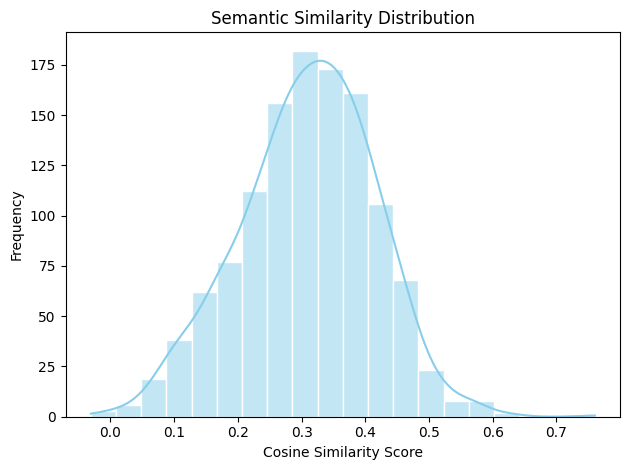

In [13]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

true_emb = model.encode(test_df["text"].tolist(), convert_to_tensor=True)
pred_emb = model.encode(test_df["predicted_label"].tolist(), convert_to_tensor=True)

sims = cosine_similarity(true_emb.cpu().numpy(), pred_emb.cpu().numpy()).diagonal()
test_df["semantic_similarity"] = sims

print("Mean Semantic Similarity:", sims.mean())

sns.histplot(sims, bins=20, kde=True, color="skyblue", edgecolor='white')
plt.title("Semantic Similarity Distribution")
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

The histogram shows the distribution of similarity scores for all test samples.

- Most similarity scores lie between **0.25 and 0.45**, following an approximately normal distribution.
- This suggests that, even when predictions are not exact, the semantic distance from the true label remains relatively small.

A low number of scores below 0.1 or above 0.6 indicates a **moderate semantic overlap** between predicted and true labels.

### Confusion Matrix Analysis

The confusion matrix provides a detailed view of the model’s predictions versus the true labels across all categories.



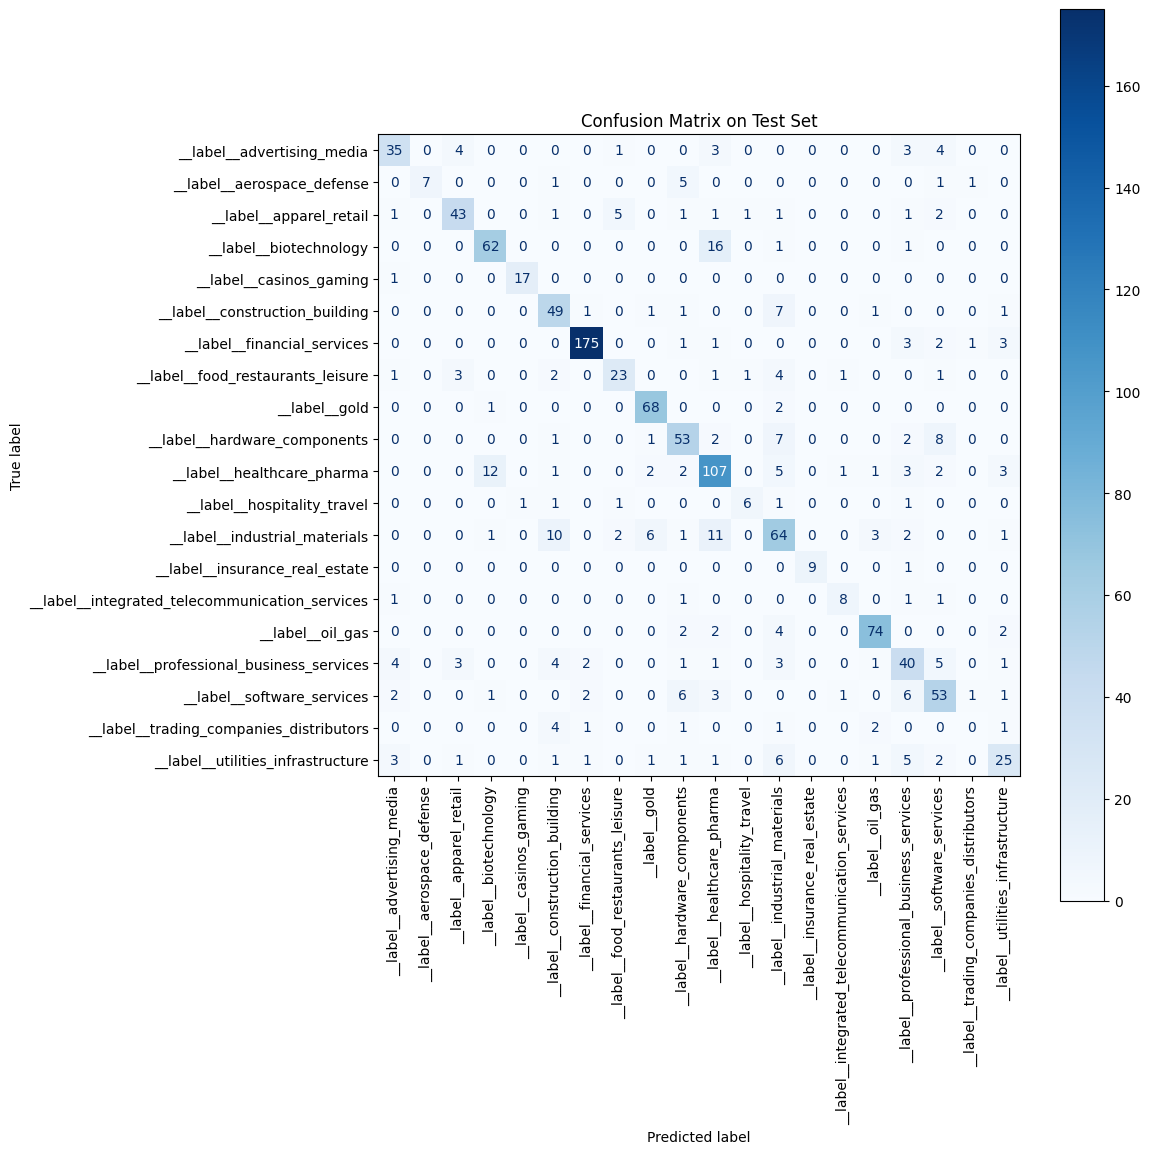

In [37]:
cm = confusion_matrix(test_df["label"], test_df["predicted_label"], labels=sorted(test_df["label"].unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(test_df["label"].unique()))

fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(include_values=True, cmap="Blues", xticks_rotation=90, ax=ax)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

#### Key Observations:

- Most predictions are concentrated on the diagonal, indicating correct classifications.
- However, several **systematic confusions** occur between semantically or functionally related categories:

  - `__label__biotechnology` is often misclassified as `__label__healthcare_pharma`, and vice versa.
  - `__label__industrial_materials` and `__label__construction_building` are also confused in multiple instances.
  - Slight overlap is visible between `__label__software_services` and `__label__professional_business_services`.

#### What This Suggests:

These confusions are understandable, as they reflect **domain similarity**:
- **Biotech and Healthcare** industries often overlap in terminology and applications.
- **Industrial materials** companies may be described similarly to those in **construction**, especially when manufacturing building materials.
- **Business services** and **software consulting** can both use similar corporate language.

This pattern implies that the model is learning useful distinctions but struggles when class definitions are **contextually similar** — highlighting an opportunity to:
- Enrich training data with **more diverse examples per class**
- Use **multi-label classification** in cases where overlap is valid.

## Final Thoughts and Conclusions

This project demonstrates the process of company classification using FastText on a labeled dataset of business descriptions.  
The key takeaways from the evaluation phase are:

- **Exact Match Accuracy** reached **76%**, indicating strong baseline performance.
- The **confusion matrix** revealed that most errors occurred between semantically similar categories such as:
  - *Biotechnology vs. Healthcare & Pharma*
  - *Industrial Materials vs. Construction & Building*
- A **semantic similarity analysis** showed that even incorrect predictions often had high contextual relevance.

### Next Steps

- Consider exploring **multi-label classification** to capture overlaps between business domains.
- Test alternative models (e.g., fine-tuned BERT or RoBERTa) for improved semantic understanding.
- Collect or augment the dataset to improve class balance and reduce label ambiguity.

This FastText-based model offers a fast and lightweight solution for company categorization, performing well with limited resources and interpretable results.
